In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import matplotlib.patches as patches
import io
import xarray as xr

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (40., 40.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [353]:
MREGIONS = {
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'JJA', [5,6,7,8,9]], # # 18
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains', 'JJA', [5,6,7,8,9]], # # 18
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'JJA', [5,6,7,8,9]], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china', 'JJA', [5,6,7,8,9]], # 4
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'JJA', [5,6,7,8,9]], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india', 'JJA', [5,6,7,8,9]], # 7
 'WAf_N' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'JJA', [5,6,7,8,9]], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'WAf_S' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,7,9], 'WAf', 'JJA', [5,6,7,8,9]],
 'australia_S' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'DJF', [11,12,1,2,3]], # 3
 'australia_N' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -17,-15], 'australia', 'DJF', [11,12,1,2,3]],
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'DJF', [11,12,1,2,3]], # 10
 'sub_SA_S' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'DJF', [11,12,1,2,3]],  # 16
 'sub_SA_N' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-28,-22], 'sub_SA', 'DJF', [11,12,1,2,3]]  # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17

}
S_REGION = 'china_W'
REGION = MREGIONS[S_REGION][7]
box = MREGIONS['australia_N'][0]

In [354]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [355]:
#era5f_pl = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/pressure_levels/*.nc')
era5f_pl = xr.open_mfdataset(glob.glob('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/pressure_levels/*.nc'))
era5f_pl = u_darrays.flip_lat(era5f_pl).sel(latitude=slice(box[2]-10,box[3]+10), longitude=slice(box[0]-10,box[1]+10))

In [356]:
#era5f_pl = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/pressure_levels/*.nc')
era5f_srfc = xr.open_mfdataset(glob.glob('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/surface/*.nc'))
era5f_srfc = u_darrays.flip_lat(era5f_srfc).sel(latitude=slice(box[2]-10,box[3]+10), longitude=slice(box[0]-10,box[1]+10))

In [357]:
era5u_mean = era5f_pl['u'].load()
era5v_mean = era5f_pl['v'].load()

In [358]:
era5f_srfc

<xarray.Dataset>
Dimensions:    (longitude: 57, latitude: 46, time: 276)
Coordinates:
  * longitude  (longitude) float32 110.5 111.2 111.9 112.6 ... 148.3 149.0 149.7
  * latitude   (latitude) float32 -36.8 -36.1 -35.4 -34.7 ... -6.7 -6.0 -5.3
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2022-12-01
Data variables: (12/18)
    u100       (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    v100       (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    ...         ...
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    vimd       (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(12, 46, 57), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-08 11:42:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [379]:
seas = [10, 11, 12]

era_uh = era5f_pl['u'].sel(time=era5f_pl['time.month'].isin(seas), level=650).groupby('time.year').mean(['time']).squeeze().load()
era_ul = era5f_pl['u'].sel(time=era5f_pl['time.month'].isin(seas), level=925).groupby('time.year').mean(['time']).squeeze().load()
era_vh = era5f_pl['v'].sel(time=era5f_pl['time.month'].isin(seas),level=650).groupby('time.year').mean(['time']).squeeze().load()
era_vl = era5f_pl['v'].sel(time=era5f_pl['time.month'].isin(seas),level=925).groupby('time.year').mean(['time']).squeeze().load()
era_t = era5f_pl['t'].sel(time=era5f_pl['time.month'].isin(seas),level=925).groupby('time.year').mean(['time']).squeeze().load()

era_ushear = era_uh-era_ul
era_vshear = era_vh-era_vl
era_shear = np.sqrt(era_ushear**2+era_vshear**2)

In [380]:
sh = era5f_srfc['sshf'].sel(time=era5f_pl['time.month'].isin(seas)).groupby('time.year').mean(['time']).squeeze().load()
sh = sh/-86400
t2 = era5f_srfc['t2m'].sel(time=era5f_pl['time.month'].isin(seas)).groupby('time.year').mean(['time']).squeeze().load()
lh = era5f_srfc['slhf'].sel(time=era5f_pl['time.month'].isin(seas)).groupby('time.year').mean(['time']).squeeze().load()
lh = lh/-86400

(array([ 9004.,  9896.,  5978.,  5840., 11153., 11035.,  4637.,  2115.,
          587.,    61.]),
 array([  1.64050148,  22.69671754,  43.75293359,  64.80914965,
         85.8653657 , 106.92158176, 127.97779782, 149.03401387,
        170.09022993, 191.14644598, 212.20266204]),
 <BarContainer object of 10 artists>)

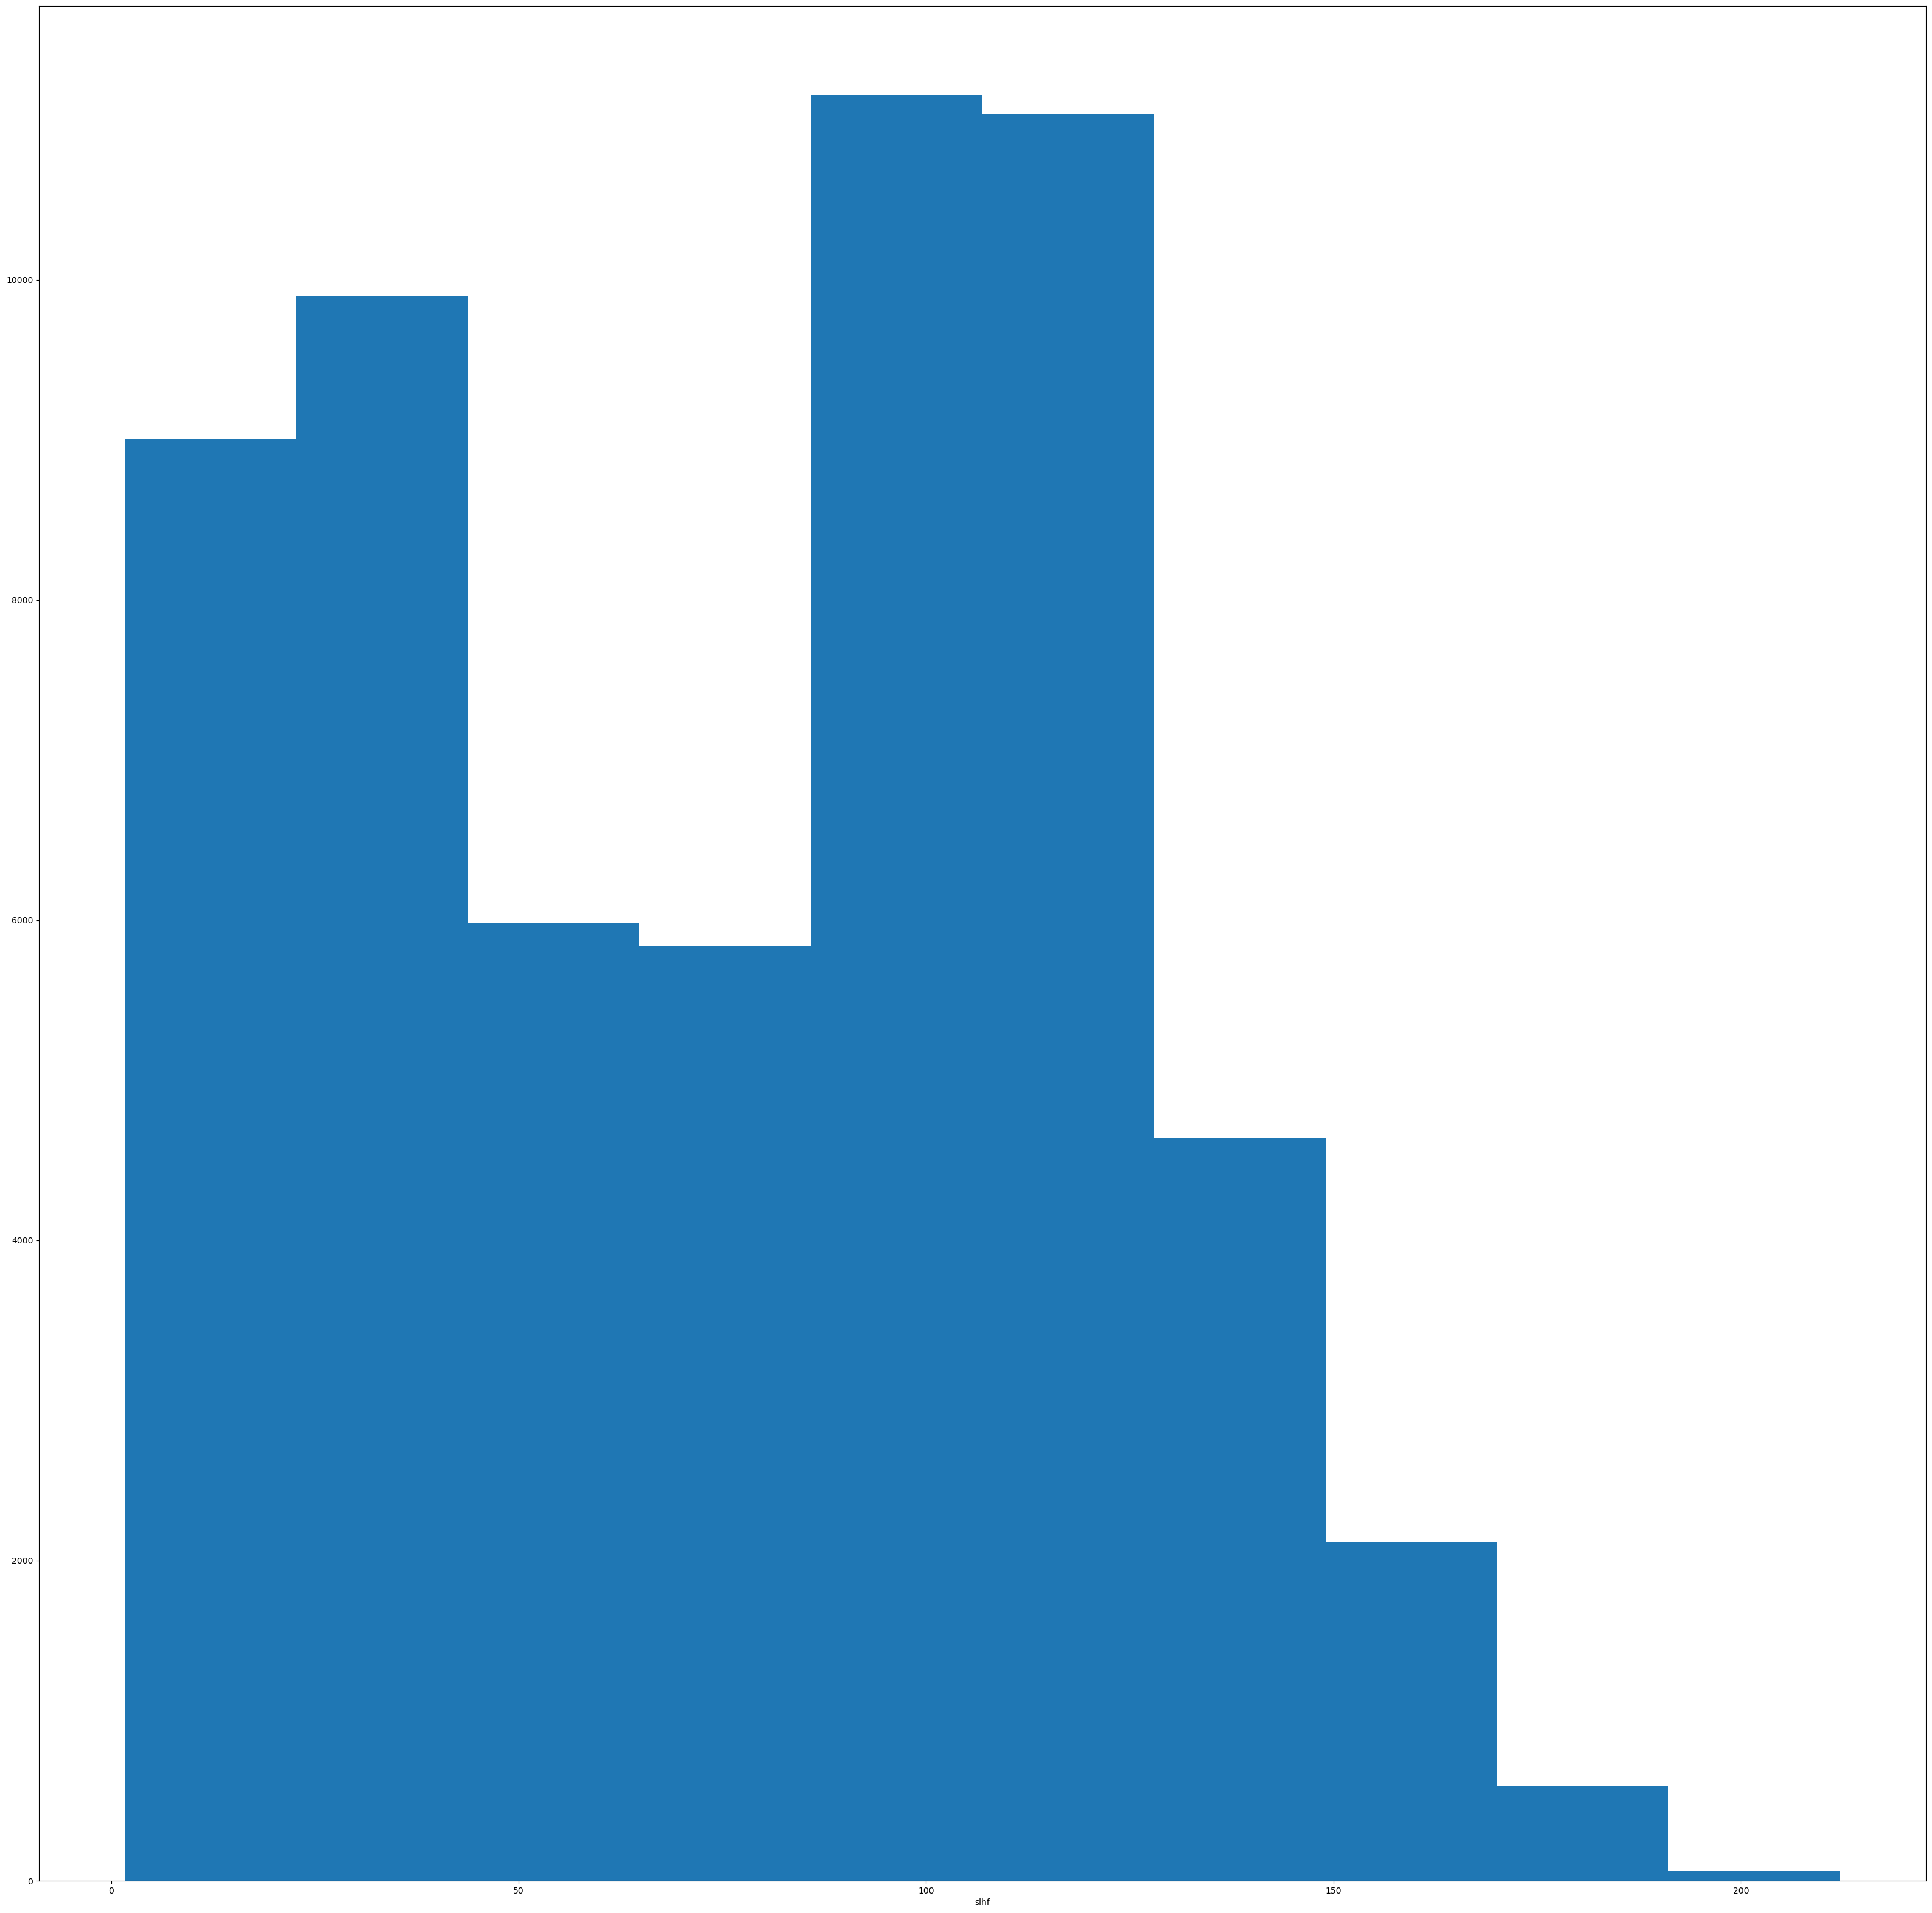

In [403]:
lh.plot()

In [381]:
shdiff = sh.differentiate('latitude')
t2diff = t2.differentiate('latitude')
lhdiff = lh.differentiate('latitude')
tdiff = era_t.differentiate('latitude')

In [382]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [383]:
import matplotlib.patches as patches
def draw_map_pixel(ax, t, lat, lon, title='', clabel='', cmap='RdBu_r', vmin=None, vmax=None):
   
    plt.pcolormesh(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.coastlines()
    
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [392]:
def calc_grad(da, tcoord='time', dim='y'):
    out = da.copy(deep=True) * np.nan
    for latid, lat in enumerate(da.latitude.values):
        for lonid, lon in enumerate(da.longitude.values):
                if dim == 'y':
                    aa = da.sel(latitude=slice(lat-1.5,lat+1.5), longitude=lon).polyfit(dim='latitude', deg=1)
                    out.values[:,latid, lonid] = aa['polyfit_coefficients'][0].values
                    
                if dim == 'x':
                    aa = da.sel(longitude=slice(lon-1.5,lon+1.5), latitude=lat).polyfit(dim='longitude', deg=1)
                    out.values[:,latid, lonid] = aa['polyfit_coefficients'][0].values
                
                #out.loc[{'year' : tt, 'latitude': lat, 'longitude': lon}] = aa['polyfit_coefficients'][0]
    return out

In [393]:
def corr(a, b, bsingle=None, c_box=None, tcoord='time'):
    ds = xr.Dataset()
    #ipdb.set_trace()
    ds['pval'] = a.copy(deep=True).sum(tcoord) * np.nan
    ds['r'] = a.copy(deep=True).sum(tcoord) * np.nan
    ds['slope'] = a.copy(deep=True).sum(tcoord) * np.nan
    ds['intercept'] = a.copy(deep=True).sum(tcoord) * np.nan

    corr_box = c_box
    perPixel = False
    if bsingle:
        bb = b
    elif c_box:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])
    else:
        perPixel=True


    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            elif c_box:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)
            elif perPixel:
                bb = b.sel(latitude=lat, longitude=lon)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

#                 if (np.nansum(aa.values == 0) >= 10):
#                     p = np.nan
#                     r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [394]:
shpoly = calc_grad(t2, tcoord='year', dim='y')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


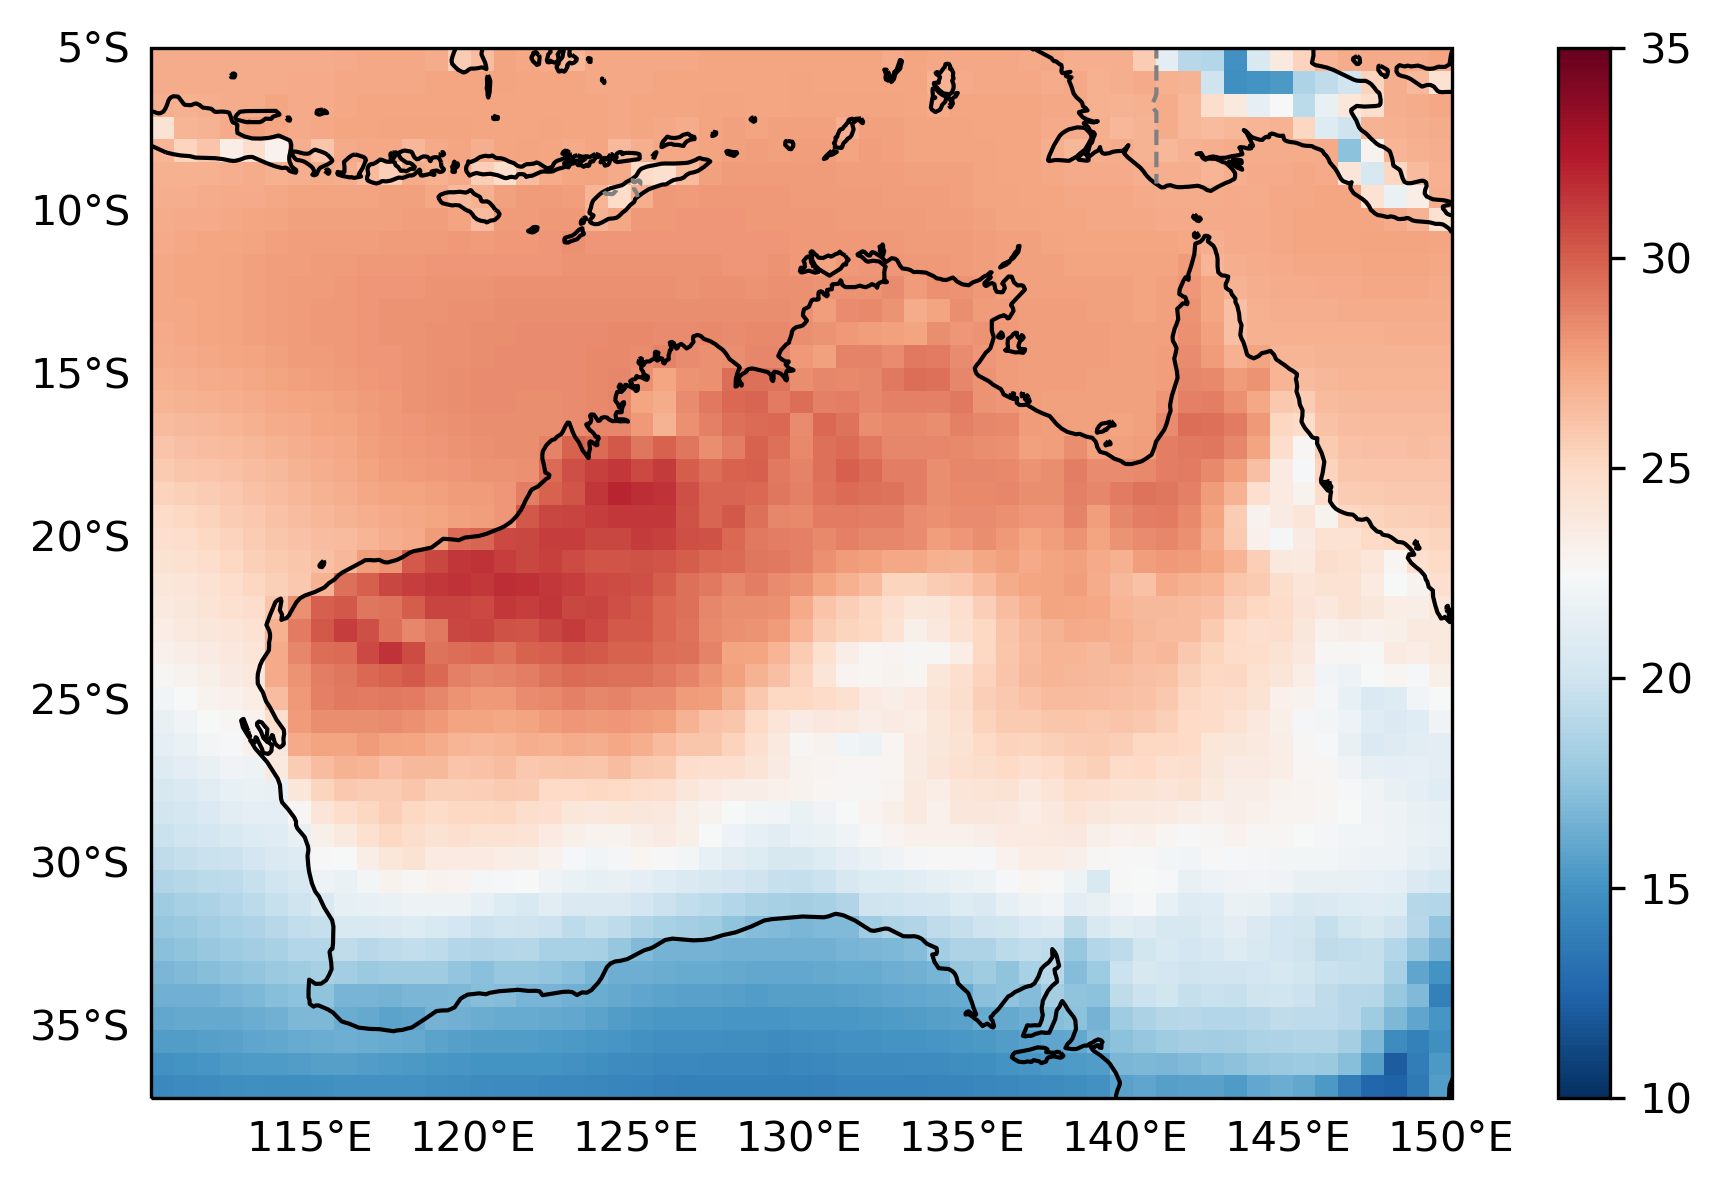

In [395]:
f = plt.figure(figsize=(20,10), dpi=300)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map_pixel(ax, t2.isel(year=10)-273.15, shpoly.latitude, shpoly.longitude, title='', clabel='', cmap='RdBu_r', vmin=10, vmax=35)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


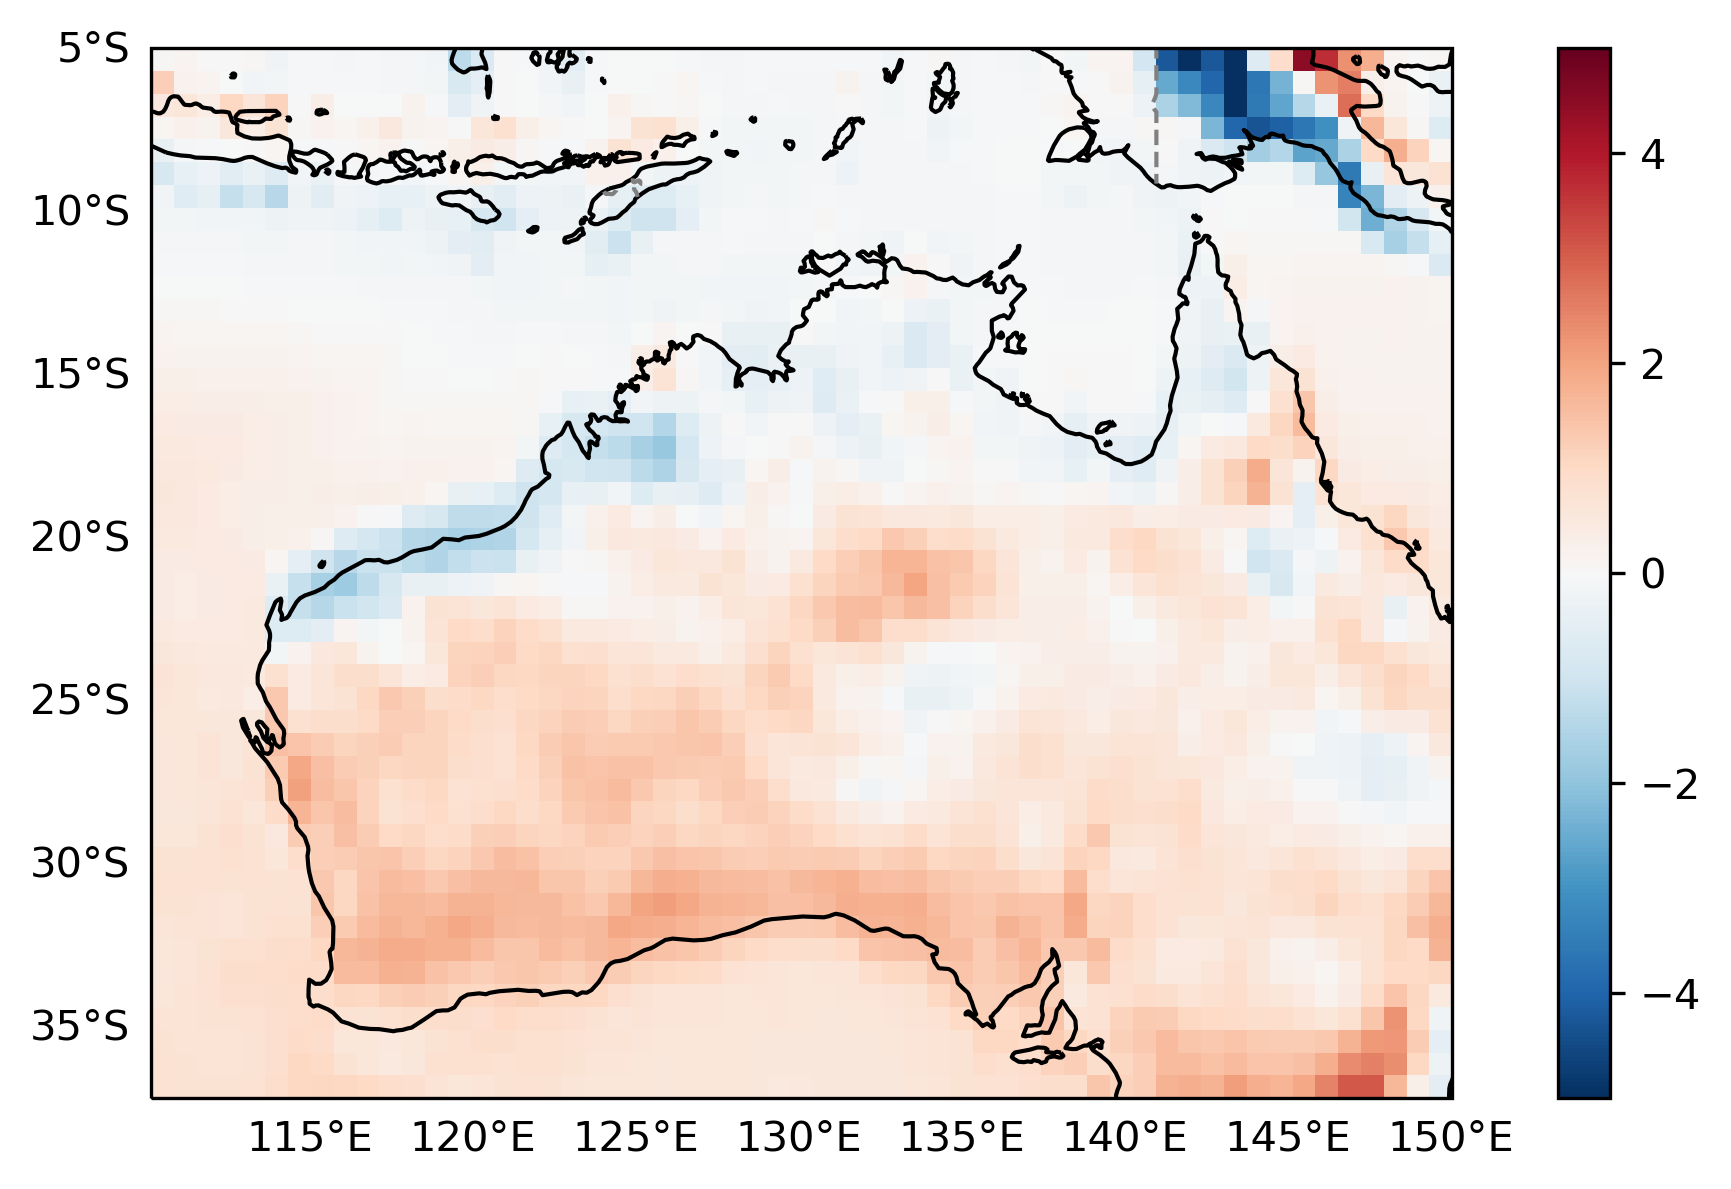

In [396]:
f = plt.figure(figsize=(20,10), dpi=300)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map_pixel(ax, shpoly.isel(year=10), shpoly.latitude, shpoly.longitude, title='', clabel='', cmap='RdBu_r', vmin=-5, vmax=5)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


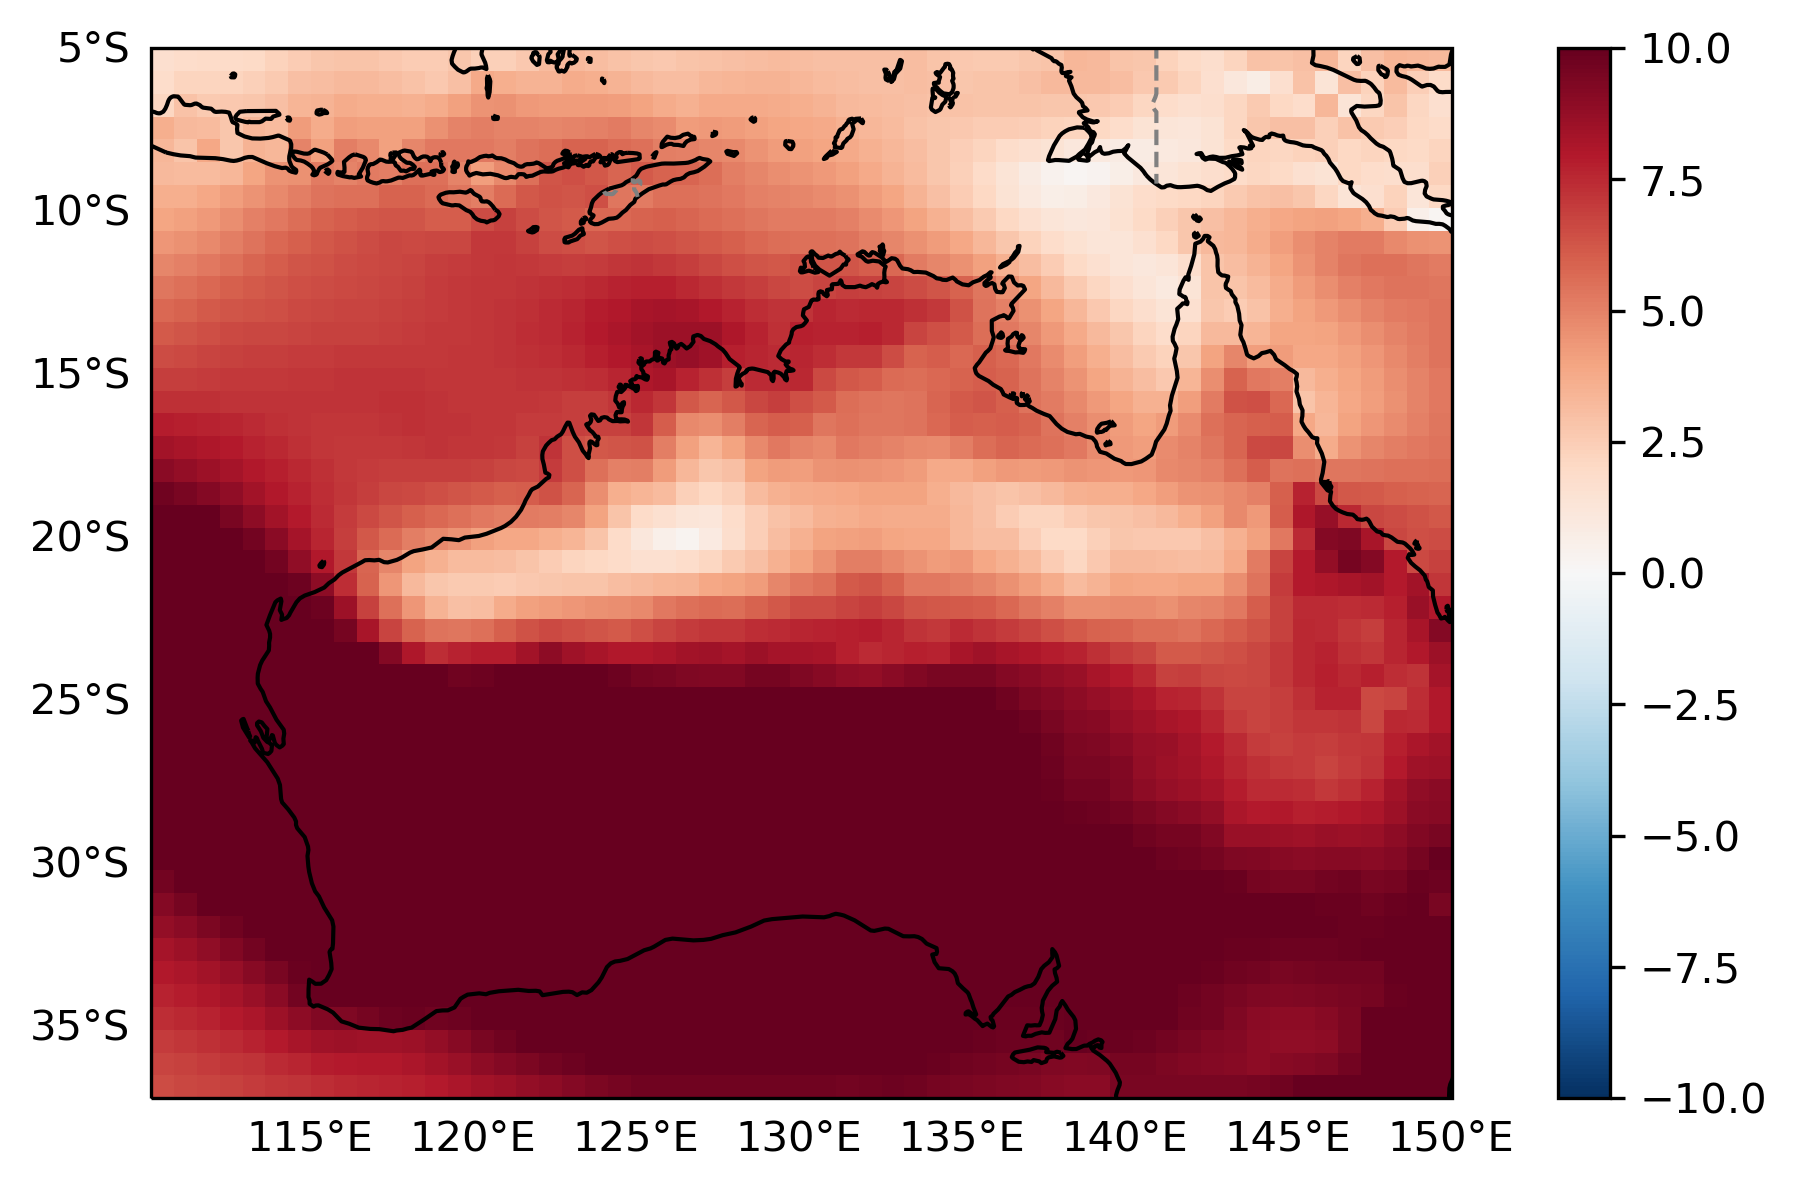

In [397]:
f = plt.figure(figsize=(20,10), dpi=300)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map_pixel(ax, era_shear.isel(year=5), shpoly.latitude, shpoly.longitude, title='', clabel='', cmap='RdBu_r', vmin=-10, vmax=10)

In [400]:
corr_ds = corr(era_shear, shpoly, tcoord='year')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


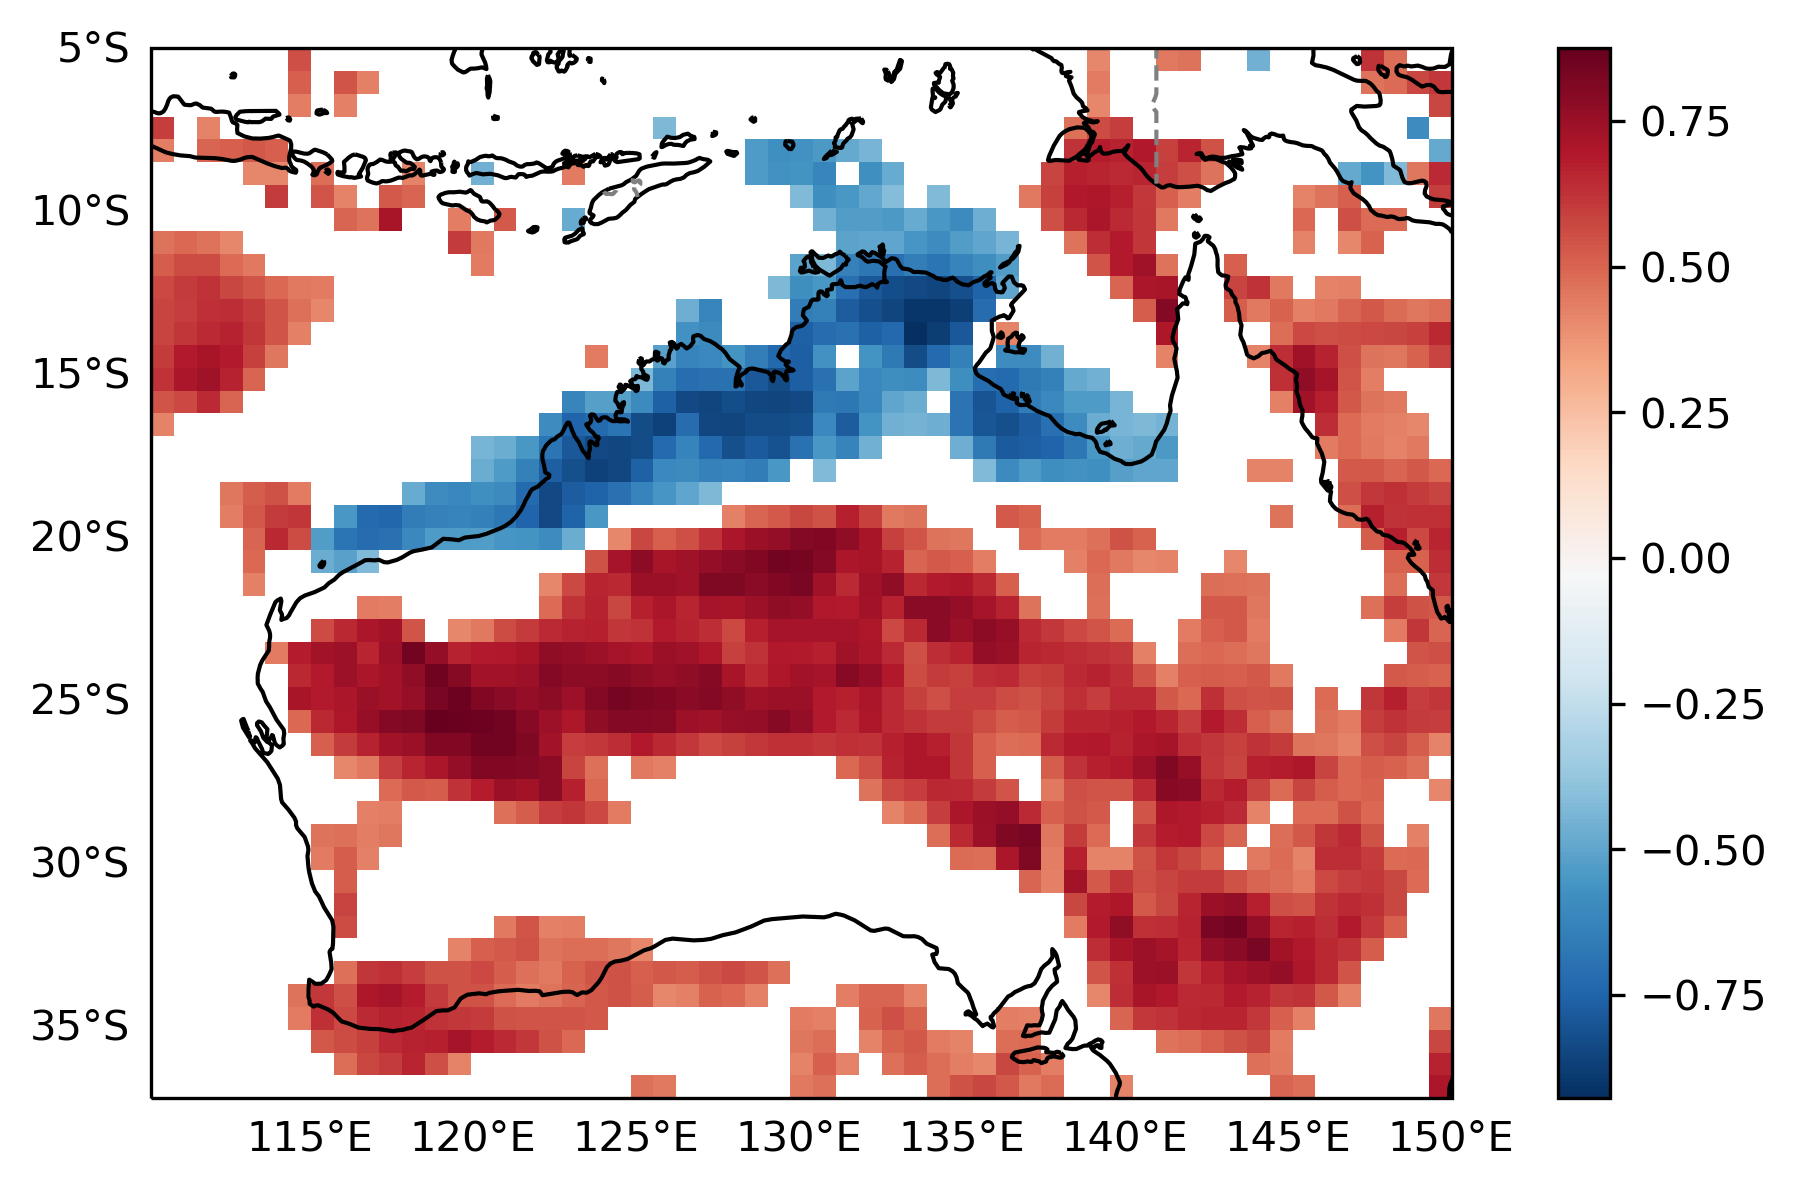

In [401]:
f = plt.figure(figsize=(20,10), dpi=300)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map_pixel(ax, corr_ds['r'].where(corr_ds['pval']<=0.05), corr_ds.latitude, corr_ds.longitude, title='', clabel='', cmap='RdBu_r')

In [92]:
corr_diff = corr(era_ushear, shdiff, tcoord='year')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


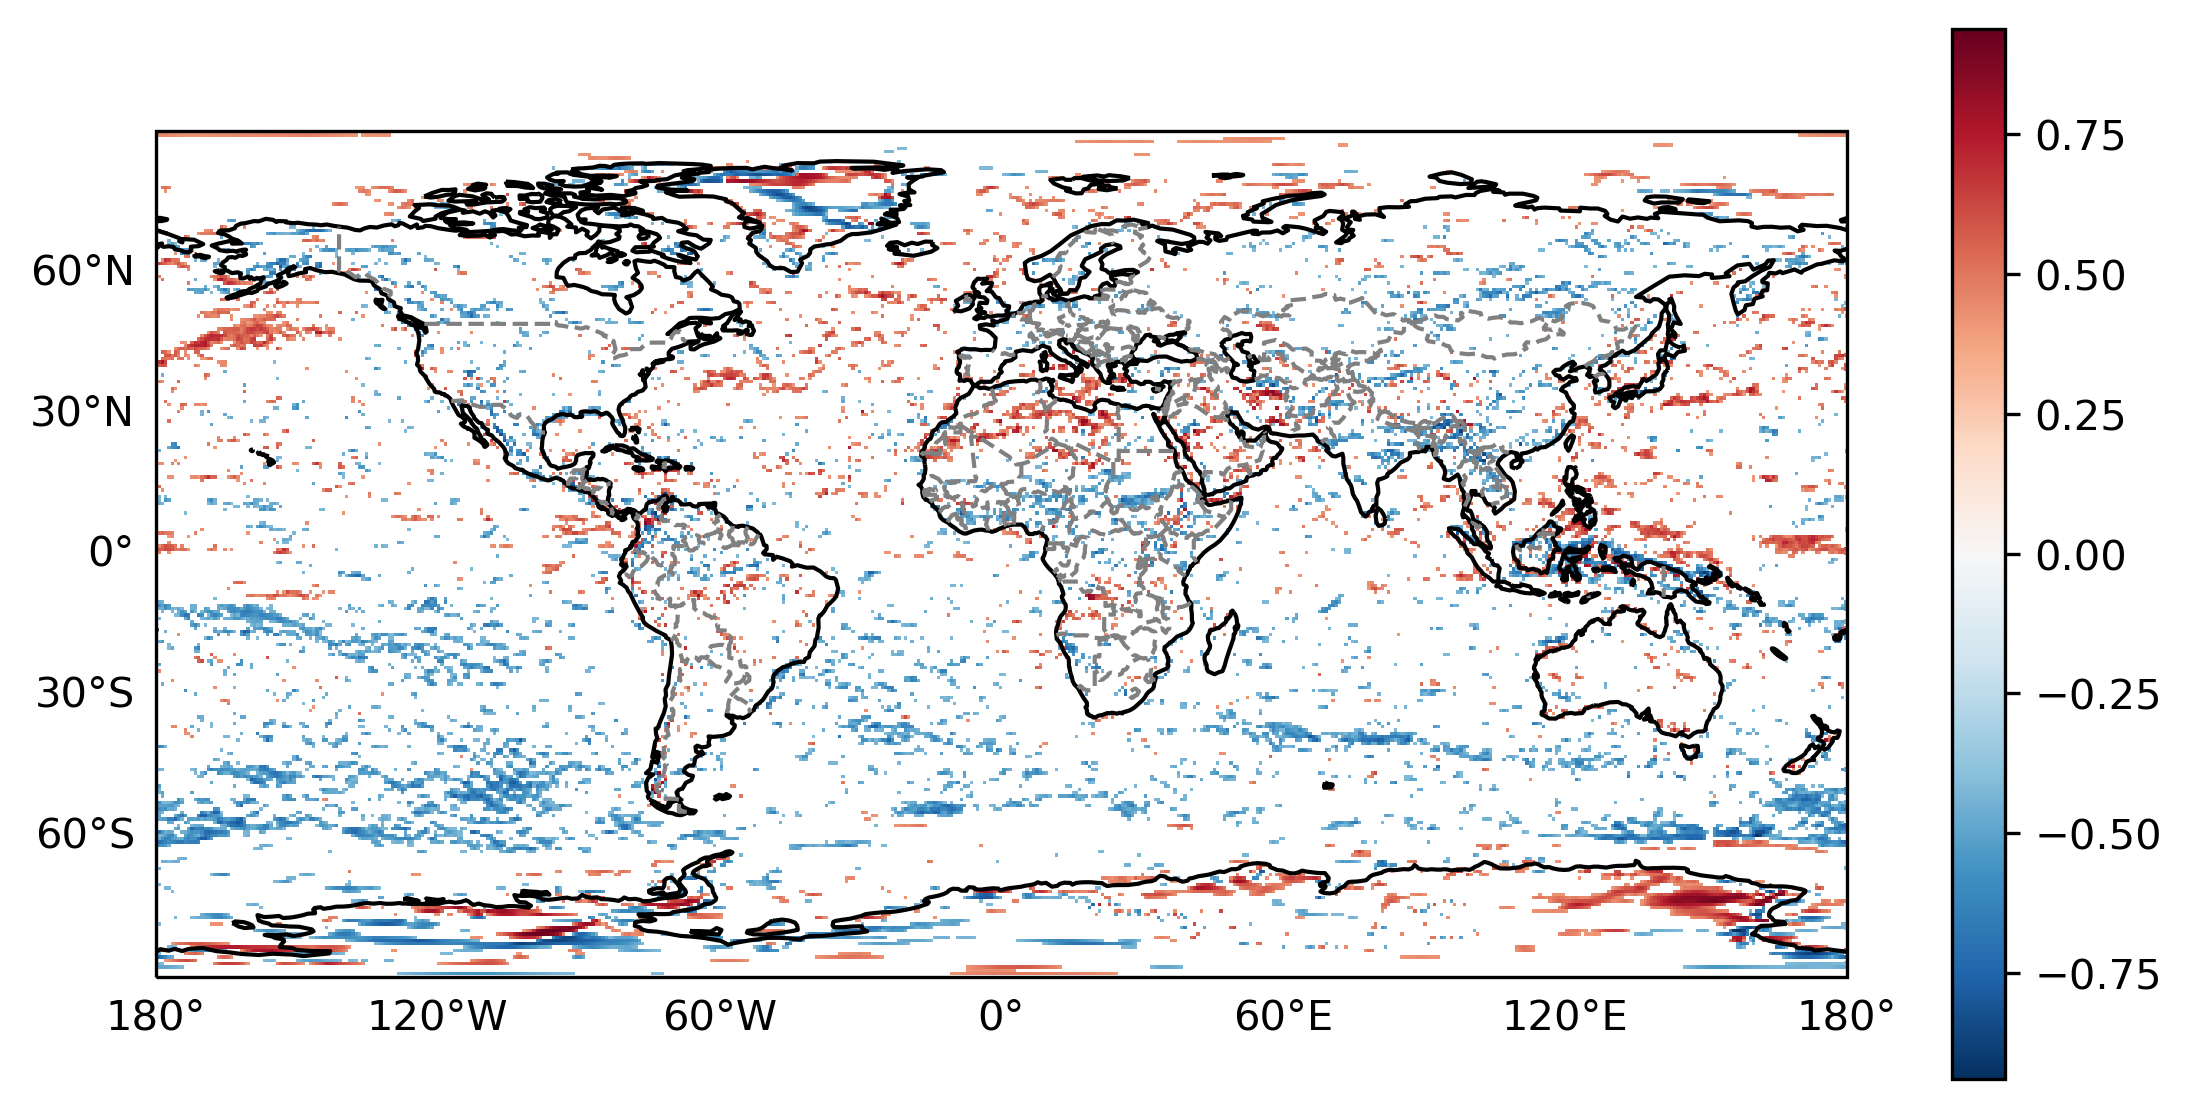

In [93]:
f = plt.figure(figsize=(20,10), dpi=300)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map_pixel(ax, corr_diff['r'].where(corr_diff['pval']<=0.05), corr_ds.latitude, corr_ds.longitude, title='', clabel='', cmap='RdBu_r')